In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Explaining why so many circuits have a sensitivity of 0.25

Comparison of two datasets with different simulation settings.

In [58]:
import numpy as np
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from common import set_theme

PALETTE = 'viridis'
set_theme()

top_write_dir = os.path.join('data', '26_sensitivity_peak2')

In [59]:
fn_dataset_og = '../data/raw/summarise_simulation/2024_11_27_145142/tabulated_mutation_info.csv'
df_og = pd.read_csv(fn_dataset_og)
    


In [60]:
dir_sim = os.path.join('..', 'notebooks', 'data', 'simulate_circuits', '2025_09_23__15_41_51')

fn1 = 'data/simulate_circuits/2026_01_12__18_50_13/analytics.json'
fn2 = 'data/simulate_circuits/2026_01_14__22_38_47/analytics.json'

# fn_analytics = os.path.join(dir_sim, 'analytics.json')
# with open(fn_analytics, 'r') as f:
#     analytics = json.load(f)
# analytics = {k: np.array(v) for k, v in analytics.items()}
    
fn_circuits = '../data/raw/generate_sequence_batch/2025_09_20_103744/circuits/rc.json'
fn_energies = '../data/raw/generate_sequence_batch/2025_09_20_103744/energies.json'

with open(fn_circuits, 'r') as f:
    circuits = json.load(f)
with open(fn_energies, 'r') as f:
    energies = json.load(f)

cols_e = [f'$RNA_{i+1}$-$RNA_{j+1}$' for i, j in zip(*np.triu_indices(3))]
energy_keys = sorted(energies.keys(), key=lambda k: int(k.split('_')[1]))


In [61]:
fn1 = 'data/simulate_circuits/2026_01_12__18_50_13/analytics.json'
fn2 = 'data/simulate_circuits/2026_01_14__22_38_47/analytics.json'

def make_df(fn_analytics):
    df = pd.DataFrame()
    with open(fn_analytics, 'r') as f:
        analytics = json.load(f)
    analytics = {k: np.array(v) for k, v in analytics.items()}
    for i, spec in zip([-3, -2, -1], [f'$RNA_1$', f'$RNA_2$', f'$RNA_3$']):
        df_curr = pd.DataFrame({k: np.array(v[:, i]) for k, v in analytics.items()})
        df_curr['Sample name'] = spec
        df_curr['circuit_idx'] = np.arange(len(df_curr))
        df = pd.concat([df, df_curr])
    df['Log sensitivity'] = np.log10(df['sensitivity'])
    df['Log precision'] = np.log10(df['precision'])
    return df.sort_values(by=['circuit_idx', 'Sample name'])

df1 = make_df(fn1)
df2 = make_df(fn2)

In [62]:
df_og['Is at peak'] = df_og['sensitivity'] == df_og[df_og['sample_name'] == 'RNA_2']['sensitivity'].value_counts().reset_index().iloc[0]['sensitivity']
df1['Is at peak'] = df1['sensitivity'] == df1[df1['Sample name'] == f'$RNA_3$']['sensitivity'].value_counts().reset_index().iloc[0]['sensitivity']
df2['Is at peak'] = df2['sensitivity'] == df2[df2['Sample name'] == f'$RNA_3$']['sensitivity'].value_counts().reset_index().iloc[0]['sensitivity']

In [63]:
max_amount = df_og[df_og['sample_name'] != 'RNA_0']['max_amount'].value_counts().index[0]
steady_state = df_og[df_og['sample_name'] != 'RNA_0']['steady_states'].value_counts().index[0]
initial_steady_state = df_og[df_og['sample_name'] != 'RNA_0']['initial_steady_states'].value_counts().index[0]
steady_state_sig = df_og[df_og['sample_name'] == 'RNA_0']['steady_states'].value_counts().index[0]
initial_steady_state_sig = df_og[df_og['sample_name'] == 'RNA_0']['initial_steady_states'].value_counts().index[0]
min_amount_sig = df_og[df_og['sample_name'] == 'RNA_0']['min_amount'].value_counts().index[0]

sensitivity = np.abs(np.divide(
    (steady_state - initial_steady_state) / initial_steady_state,
    (steady_state_sig - initial_steady_state_sig) / initial_steady_state_sig
))
{'sensitivity': sensitivity,
 'max_amount': max_amount,
 'steady_state': steady_state,
 'initial_steady_state': initial_steady_state,
 'steady_state_sig': steady_state_sig,
 'initial_steady_state_sig': initial_steady_state_sig, 
 'min_amount_sig': min_amount_sig}

{'sensitivity': np.float64(0.00033418855885369706),
 'max_amount': np.float64(199.73245),
 'steady_state': np.float64(199.66588),
 'initial_steady_state': np.float64(199.73245),
 'steady_state_sig': np.float64(398.93137),
 'initial_steady_state_sig': np.float64(199.73245),
 'min_amount_sig': np.float64(199.73245)}

In [64]:
max_amount2 = df2[df2['Sample name'] !=
                  f'$RNA_1$']['max_amount'].value_counts().index[0]
steady_state2 = df2[df2['Sample name'] !=
                    f'$RNA_1$']['steady_states'].value_counts().index[0]
initial_steady_state2 = df2[df2['Sample name'] !=
                            f'$RNA_1$']['initial_steady_states'].value_counts().index[0]
steady_state_sig2 = df2[df2['Sample name'] ==
                        f'$RNA_1$']['steady_states'].value_counts().index[0]
initial_steady_state_sig2 = df2[df2['Sample name'] ==
                                f'$RNA_1$']['initial_steady_states'].value_counts().index[0]
min_amount_sig2 = df2[df2['Sample name'] ==
                                f'$RNA_1$']['min_amount'].value_counts().index[0]

sensitivity2 = np.abs(np.divide(
    (steady_state2 - initial_steady_state2) / initial_steady_state2,
    (steady_state_sig2 - initial_steady_state_sig2) / initial_steady_state_sig2
))
{'sensitivity2': sensitivity2,
 'max_amount2': max_amount2,
 'steady_state2': steady_state2,
 'initial_steady_state2': initial_steady_state2,
 'steady_state_sig2': steady_state_sig2,
 'initial_steady_state_sig2': initial_steady_state_sig2,
 'min_amount_sig2': min_amount_sig2}

{'sensitivity2': np.float64(0.24942791762013727),
 'max_amount2': np.float64(199.73231506347656),
 'steady_state2': np.float64(199.66578674316406),
 'initial_steady_state2': np.float64(199.73231506347656),
 'steady_state_sig2': np.float64(398.9311828613281),
 'initial_steady_state_sig2': np.float64(399.4646301269531),
 'min_amount_sig2': np.float64(398.9311828613281)}

In [65]:
sensitivity2 / sensitivity 
((steady_state2 - initial_steady_state2) / initial_steady_state2) / (
    (steady_state - initial_steady_state) / initial_steady_state)
((steady_state_sig - initial_steady_state_sig) / initial_steady_state_sig) / (
    (steady_state_sig2 - initial_steady_state_sig2) / initial_steady_state_sig2)
(steady_state_sig - initial_steady_state_sig), (steady_state_sig2 - initial_steady_state_sig2)
min_amount_sig2

np.float64(398.9311828613281)

In [66]:
config_df_og = {
    "dt0": 0.01,
    "starting_copy_number": 200
    }
config_df1 = {
    "dt0": 0.0001,
    "starting_copy_number": 100
    }
config_df2 = {
    "dt0": 0.0001,
    "starting_copy_number": 200
    }

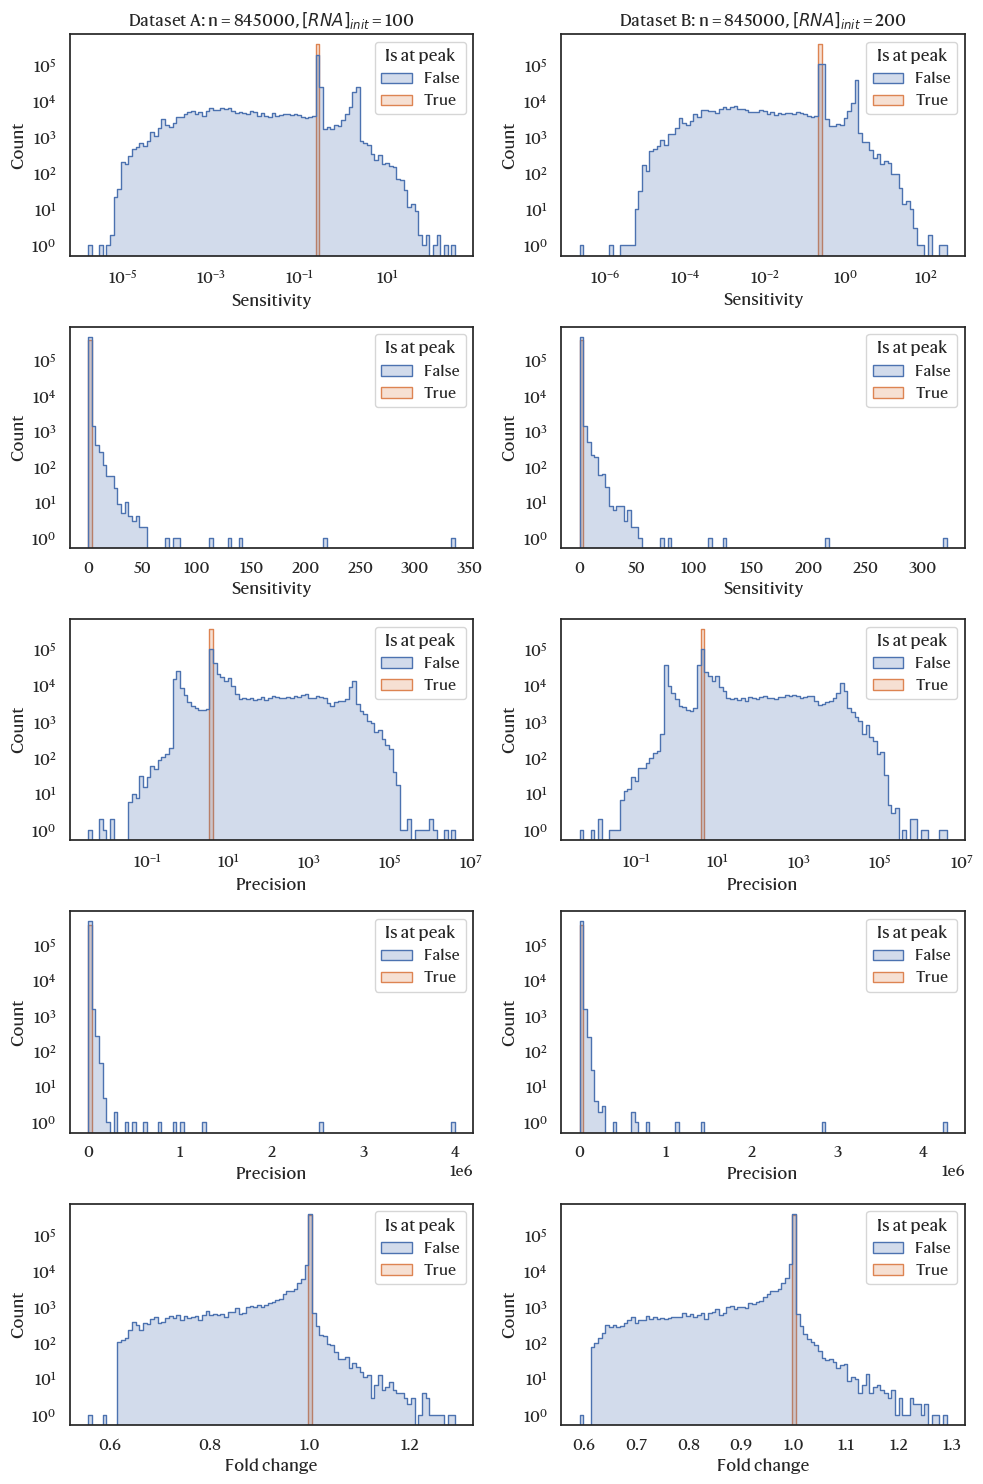

In [67]:
def plot(col, use_log, i, df_A, df_B, filtA, filtB, axs, cfg_A, cfg_B,
         label_A='Dataset A', label_B='Dataset B'):
    sns.histplot(df_A[filtA], x=col, hue='Is at peak',
                element='step', bins=100, log_scale=(use_log, False), ax=axs[i, 0])
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_xlabel(col.replace('_', ' ').capitalize())
    if i == 0: axs[i, 0].set_title(f'{label_A}: n = {len(df_A[filtA])}, $[RNA]_{{init}}$ = {cfg_A["starting_copy_number"]}')
    
    sns.histplot(df_B[filtB], x=col, hue='Is at peak',
                element='step', bins=100, log_scale=(use_log, False), ax=axs[i, 1])
    axs[i, 1].set_yscale('log')
    axs[i, 1].set_xlabel(col.replace('_', ' ').capitalize())
    if i == 0: axs[i, 1].set_title(f'{label_B}: n = {len(df_B[filtB])}, $[RNA]_{{init}}$ = {cfg_B["starting_copy_number"]}')
        
fig, axs = plt.subplots(5, 2, figsize=(5*2, 3*5))

ii = 0
filt_og = (df_og['sample_name'] == 'RNA_2')
filt1 = df1['Sample name'] == f'$RNA_3$'
filt2 = df2['Sample name'] == f'$RNA_3$'
for col in ['sensitivity', 'precision']:
    for i, use_log in enumerate((True, False), start=ii):
        plot(col, use_log, i, df1, df2, filt1, filt2, axs, config_df1, config_df2)

    # for i, col in zip([2, 3], ['precision', 'fold_change']):
    #     sns.histplot(df1[filt1], x=col, hue='Is at peak',
    #                  element='step', bins=100, ax=axs[i, 0])
    #     axs[i, 0].set_yscale('log')
    #     sns.histplot(df2[filt2], x=col, hue='Is at peak',
    #                  element='step', bins=100, ax=axs[i, 1])
    #     axs[i, 1].set_yscale('log')
    ii += 2

plot('fold_change', False, 4, df1, df2, filt1, filt2, axs, config_df1, config_df2)

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'sensitivity_peak_histograms.png'), dpi=300,
            bbox_inches='tight')

Text(0.5, 1.0, 'Dataset 2')

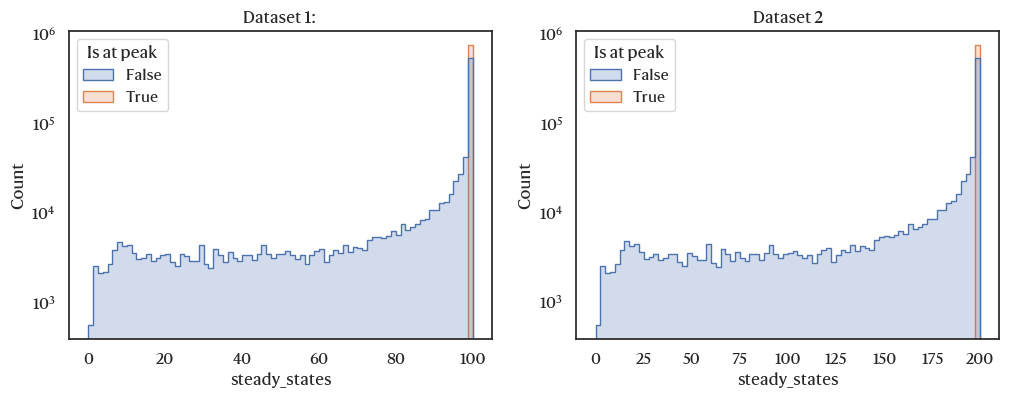

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))
# sns.histplot(df_og[df_og['sample_name'] != 'RNA_0'], x='steady_states', 
sns.histplot(df1[df1['Sample name'] != f'$RNA_1$'], x='steady_states', 
             hue='Is at peak', element='step', bins=80, ax=axs[0])
            #  hue='sample_name', element='step', bins=80, ax=axs[0])
axs[0].set_yscale('log')
axs[0].set_title('Dataset 1: ')
sns.histplot(df2[df2['Sample name'] != f'$RNA_1$'], x='steady_states', 
             hue='Is at peak', element='step', bins=80, ax=axs[1])
            #  hue='Sample name', element='step', bins=80, ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title('Dataset 2')

In [69]:
# cols_plot = [
#     'sensitivity', 'precision', 'initial_steady_states', 'steady_states', 'fold_change', 'overshoot']

# nrows = 3
# ncols = int(np.ceil(len(cols_plot) / nrows))
# fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))

# for ax, col in zip(axs.flat, cols_plot):
#     sns.histplot(data=df1[df1['sample_name'] != 'RNA_0'], 
#                  x=col, hue='Is at peak', 
#                  bins=100, element='step', ax=ax,
#                  log_scale=(True, False) if col in (
#                      'sensitivity', 'precision') else (False, False))
#     ax.set_yscale('log')
#     ax.set_xlabel(col.replace('_', ' ').capitalize())
#     # ax.set_title(col.replace('_', ' ').title())

# plt.tight_layout()


# Look at binding energies of peak circuits

In [70]:
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols

cols_e1 = get_true_interaction_cols(df_og, 'energies', remove_symmetrical=True)

# df2[cols_e1] = np.nan
# for i in df2['Sample name'].unique():
#     df2.loc[df2['Sample name'] == i, cols_e1] = pd.DataFrame(energies).values

def add_energies(df):
    df[cols_e1] = np.nan
    for i in df['Sample name'].unique():
        df[cols_e1] = df_og[cols_e1].values
    return df

df1 = add_energies(df1)
df2 = add_energies(df2)

In [71]:
pd.DataFrame(df_og[df_og['Is at peak']][cols_e1].value_counts())

count
energies_0-0 energies_0-1 energies_0-2 energies_1-1 energies_1-2 energies_2-2        
0.0          0.0          0.0           0.00        0.0           0.00         742084
                                                                 -1.46            182
                                       -1.40        0.0           0.00             96
                                        0.00        0.0          -1.84             38
                                       -1.42        0.0           0.00             29
                                        0.00        0.0          -1.42             14
                                       -1.20        0.0           0.00              7
                                        0.00        0.0          -1.40              5
                                       -1.47        0.0           0.00              4
                                        0.00        0.0          -2.41              4
                                                                 -1.34              4
                                       -1.10        0.0           0.00              3
                                        0.00        0.0          -1.29              2
                                                                 -0.25              2
                                       -1.34        0.0           0.00              2
                                       -2.41        0.0           0.00              1
                                       -0.78        0.0           0.00              1

In [72]:
pd.DataFrame(df2[df2['Is at peak']][cols_e1].value_counts())

count
energies_0-0 energies_0-1 energies_0-2 energies_1-1 energies_1-2 energies_2-2        
0.0          0.0          0.0           0.00        0.0          0.0           742084
                                       -0.37        0.0          0.0                1

# Compare original mutation dataset with its resimulated couterpart

In [73]:
# fn_resim = fn_dataset1.replace('.csv', '_resimulated_2026_01_12__18_50_13.csv')
# if os.path.exists(fn_resim):
#     df_resim = pd.read_csv(fn_resim)
# else:
#     dir_resim = 'data/simulate_circuits/2026_01_12__18_50_13'
#     analytics = pd.read_json(os.path.join(dir_resim, 'analytics.json'))

#     df_resim = df_og # pd.read_csv(fn_dataset1)
#     n_samples = df_resim['sample_name'].nunique()
#     for k in analytics.keys():
#         values = analytics[k].explode(
#             ).to_numpy().reshape(len(df_resim)//n_samples, -1)[:, -n_samples:].flatten()
#         df_resim[k] = values
#     df_resim.to_csv(fn_resim, index=False)
df_resim = df1

In [74]:
df_resim['sample_name'] = df_og['sample_name'].values
# df_resim['Is at peak'] = df_resim['sensitivity'] == df_resim[
#     df_resim['sample_name'] == 'RNA_2']['sensitivity'].value_counts(
#         ).reset_index().iloc[0]['sensitivity']

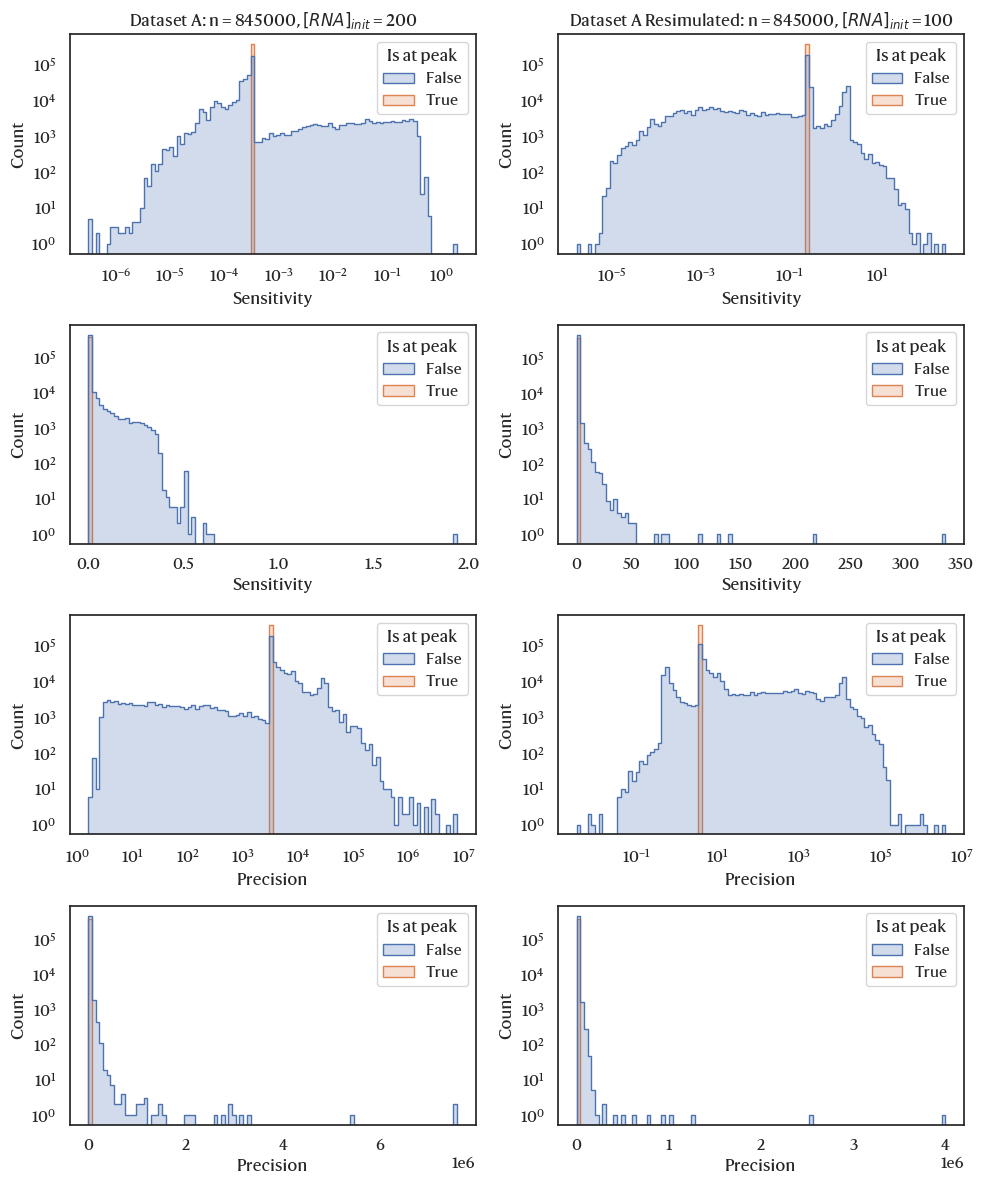

In [75]:
fig, axs = plt.subplots(4, 2, figsize=(5*2, 3*4))

ii = 0
filt1 = (df_og['sample_name'] == 'RNA_2')
filt_resim = (df_resim['sample_name'] == 'RNA_2')
for col in ['sensitivity', 'precision']:
    for i, use_log in enumerate((True, False), start=ii):
        plot(col, use_log, i, df_og, df_resim, filt1, filt_resim, axs,
             config_df_og, config_df1,
             label_B='Dataset A Resimulated')
    ii += 2

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'resimulated_sensitivity_peak_sp.png'), dpi=300,
            bbox_inches='tight')

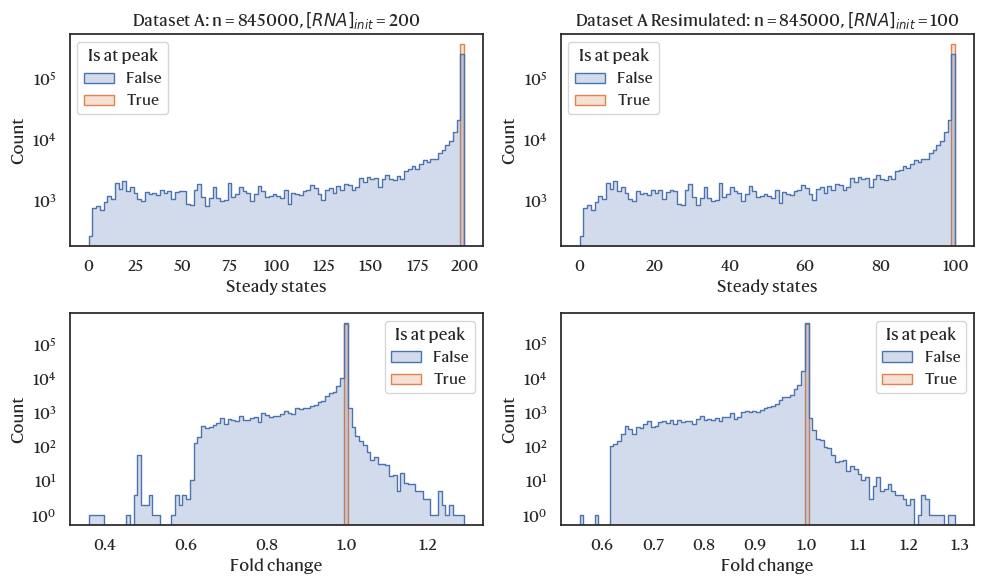

In [76]:
fig, axs = plt.subplots(2, 2, figsize=(5*2, 3*2))

ii = 0
filt1 = (df_og['sample_name'] == 'RNA_2')
filt_resim = (df_resim['sample_name'] == 'RNA_2')
use_log = False
for i, col in enumerate(['steady_states', 'fold_change']):
    plot(col, use_log, i, df_og, df_resim, filt1, filt_resim, axs,
         config_df_og, config_df1,
         label_B='Dataset A Resimulated')

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'resimulated_sensitivity_peak_ststf.png'), dpi=300,
            bbox_inches='tight')

# Examine traces

In [77]:
idxs = np.array(df2[df2['Is at peak']].index[:1000])
ts = np.load('data/simulate_circuits/2025_09_23__15_41_51/ts.npy')
ys = np.load('data/simulate_circuits/2025_09_23__15_41_51/ys.npy')[
    idxs]
ys.shape, ts.shape

((1000, 500, 9), (500,))

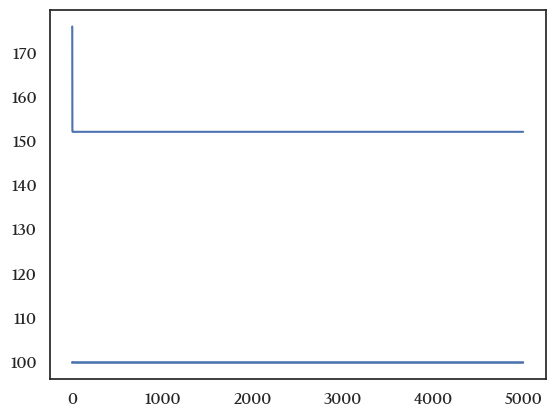

In [78]:
# plt.plot((np.ones((1000, len(ts))) * ts).T, ys[:1000, :, -1].T,
#          alpha=0.1, color='b')
# plt.show()
plt.plot(ts, ys[0, :, -3:], color='b')

In [79]:
# idxs = np.array(df2[df2['Is at peak']].index[:1000])

# y00s = np.load('data/simulate_circuits/2025_09_23__15_41_51/y00s.npy')[idxs]
# y0m = np.load('data/simulate_circuits/2025_09_23__15_41_51/y0m.npy')[idxs]
# ts0 = np.load('data/simulate_circuits/2025_09_23__15_41_51/ts0.npy')
# y00s.shape, y0m.shape, ts0.shape